# TFT using GluonTS 

In [1]:
import os
import json
from copy import deepcopy
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import gluon
from mxnet import nd, sym
from mxnet.gluon import nn, HybridBlock

from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.common import (
    FileDataset, ListDataset, TrainDatasets,
    CategoricalFeatureInfo, BasicFeatureInfo,
)
from gluonts.dataset.loader import TrainDataLoader, InferenceDataLoader
from gluonts.model.tft import *
from gluonts.mx.trainer import Trainer
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions


c:\Users\DuanyiWei\anaconda3\envs\pytorch\lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "
c:\Users\DuanyiWei\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\DuanyiWei\AppData\Roaming\Python\Python37\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend settin

In [21]:
def gpu_device(gpu_number=0):
    try:
        _ = mx.nd.array([1, 2, 3], ctx=mx.gpu(gpu_number))
    except mx.MXNetError:
        return None
    return mx.gpu(gpu_number)

In [22]:
if not gpu_device():
    print('No GPU device found!')

No GPU device found!


In [23]:
data = get_dataset('electricity')
metadata = data.metadata
train_set = data.train
test_set = data.test

In [25]:
# artifical static categorical features
metadata.feat_static_cat = [
    CategoricalFeatureInfo(name='static_cat_1', cardinality='100'),
    CategoricalFeatureInfo(name='static_cat_2', cardinality='200'),
]
# artifical static real features
metadata.feat_static_real = [
    BasicFeatureInfo(name='static_real_1'),
    BasicFeatureInfo(name='static_real_2'),
]
# artifical dynamic categorical features
metadata.feat_dynamic_cat = [
    CategoricalFeatureInfo(name='dynamic_cat_1', cardinality='50'),
    CategoricalFeatureInfo(name='dynamic_cat_2', cardinality='80'),
]
# artifical dynamic real features
metadata.feat_dynamic_real = [
    BasicFeatureInfo(name='dynamic_real_1'),
    BasicFeatureInfo(name='dynamic_real_2'),
]
# indicate unknown dynamic features
feat_past_dynamic = ['dynamic_cat_1', 'dynamic_real_2']
# indicate dimension of dynamic real features (other than the temporal dimension)
# it'd be better specified in FeatureInfo in the future
static_real_1_dim = 2 
static_real_2_dim = 3
dynamic_real_1_dim = 4
dynamic_real_2_dim = 5

# generate random features for each data entry
train = []
for entry in train_set:
    length = len(entry['target'])
    train.append({
        'target': entry['target'],
        'start': entry['start'],
        'static_cat_1': np.random.randint(100, size=(1,)),
        'static_cat_2': np.random.randint(200, size=(1,)),
        'static_real_1': np.random.randn(static_real_1_dim),
        'static_real_2': np.random.randn(static_real_2_dim),
        'dynamic_cat_1': np.random.randint(50, size=(length,)),
        'dynamic_cat_2': np.random.randint(80, size=(length,)),
        'dynamic_real_1': np.random.randn(dynamic_real_1_dim, length),
        'dynamic_real_2': np.random.randn(dynamic_real_2_dim, length),
    })
train = ListDataset(train, metadata.freq)

test = []
for entry in test_set:
    length = len(entry['target'])
    test.append({
        'target': entry['target'],
        'start': entry['start'],
        'static_cat_1': np.random.randint(100, size=(1,)),
        'static_cat_2': np.random.randint(200, size=(1,)),
        'static_real_1': np.random.randn(static_real_1_dim),
        'static_real_2': np.random.randn(static_real_2_dim),
        'dynamic_cat_1': np.random.randint(50, size=(length,)),
        'dynamic_cat_2': np.random.randint(80, size=(length,)),
        'dynamic_real_1': np.random.randn(dynamic_real_1_dim, length),
        'dynamic_real_2': np.random.randn(dynamic_real_2_dim, length),
    })
test = ListDataset(test, metadata.freq)

dataset = TrainDatasets(metadata=metadata, train=train, test=test)

In [10]:
trainer = Trainer(
    # ctx=mx.gpu(0),
    epochs = 10,
    batch_size = 32,
    num_batches_per_epoch=1000,
    learning_rate = 2e-3,
    patience = 5,
    minimum_learning_rate = 1e-5,
    clip_gradient = 10.0,
    weight_decay = 1e-4,
    hybridize = False, 
)

In [11]:
estimator = TemporalFusionTransformerEstimator(
    freq = dataset.metadata.freq,
    context_length=168,
    prediction_length = dataset.metadata.prediction_length,
    trainer=trainer,
    hidden_dim=32,
    variable_dim=8, # this is the dimension of variable embeddings; in the original paper it is always `hidden_dim`
    num_heads=4,
    num_outputs=3, # number of quantiles to be predicted. E.g. [0.5,0.1,0.9] for `num_outputs=3` and [0.5,0.1,0.9,0.2,0.8] for `num_outputs=5`
    num_instance_per_series=100,
    dropout_rate=0.1,
    static_cardinalities={
        info.name: int(info.cardinality) 
        for info in dataset.metadata.feat_static_cat
    }, # cardinalities of static categorical features
    dynamic_cardinalities={
        info.name: int(info.cardinality)
        for info in dataset.metadata.feat_dynamic_cat
    }, # cardinalities of dynamic categorical features
    static_feature_dims={
        info.name: eval(f"{info.name}_dim")
        for info in dataset.metadata.feat_static_real
    }, # dimensions of static real features
    dynamic_feature_dims={
        info.name: eval(f"{info.name}_dim")
        for info in dataset.metadata.feat_dynamic_real
    }, # dimensions of dynamic real features
    past_dynamic_features=feat_past_dynamic,
)

In [12]:
predictor = estimator.train(dataset.train)

100%|██████████| 1000/1000 [13:05<00:00,  1.27it/s, epoch=10/10, avg_epoch_loss=54.9]


In [ ]:
from gluonts.dataset.util import to_pandas
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx import Trainer
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [ ]:
url= (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url,index_col=0, parse_dates=True)


In [ ]:
remove_ind = np.random.choice(np.arange(df.shape[0]), size=100, replace=False)
mask = [False if i in remove_ind else True for i in range(df.shape[0])]
df_missing_val = df.loc[mask, :]

In [ ]:
max_end = max(df_missing_val.groupby("item_id").apply(lambda _df: _df.index[-1]))
dfs_dict = {}
for item_id, gdf in df_missing_val.groupby("item_id"):
    new_index = pd.date_range(gdf.index[0], end=max_end, freq="1H")
    dfs_dict[item_id] = gdf.reindex(new_index).drop("item_id", axis=1)

ds = PandasDataset(dfs_dict, target="target")

In [ ]:
dfs_dict.keys()

dict_keys(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])

In [ ]:
gdf.reindex(new_index).drop("item_id", axis=1)

,target
2021-01-01 00:00:00,1.3763
2021-01-01 01:00:00,1.2750
2021-01-01 02:00:00,0.6767
2021-01-01 03:00:00,0.5150
2021-01-01 04:00:00,0.1708
...,...
2021-01-10 19:00:00,1.2349
2021-01-10 20:00:00,1.1525
2021-01-10 21:00:00,1.1485
2021-01-10 22:00:00,1.3248


In [ ]:
dataset = get_dataset('airpassengers')

deepar = DeepAREstimator(prediction_length=12, freq="M", trainer=Trainer(epochs=5))
model = deepar.train(dataset.train)



100%|██████████| 50/50 [00:02<00:00, 22.24it/s, epoch=5/5, avg_epoch_loss=4]


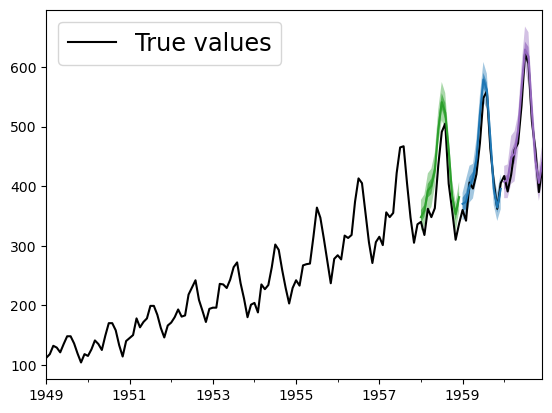

In [ ]:
# Model predictions
y = to_pandas(list(dataset.test)[0])
y.to_timestamp().plot(color='k')

x_test = PandasDataset([y[:-36], y[:-24], y[:-12]])
y_pred = model.predict(x_test)

for color, pred in zip(["green", "blue", "purple"], y_pred):
    pred.plot(color=f"tab:{color}")

plt.legend(["True values"], loc="upper left", fontsize="xx-large")

In [ ]:
start = pd.Period("01-01-2022", freq='1H')

# eletricity consumptions

In [ ]:
# Download TFT. Kudos to greatwhiz for making TFT compatible to TF # 2.x!
!git clone https://github.com/greatwhiz/tft_tf2.git

# Install any missing libraries in Conda environment
%pip install pyunpack
%pip install wget

In [ ]:
# The structure of the command is:
# python3 -m script_download_data $EXPT $OUTPUT_FOLDER
%run tft_tf2/script_download_data.py electricity electricity_dataset

In [ ]:
import wget, zipfile
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# from darts.timeseries import TimeSeries
# from darts.models import NBEATSModel, TFTModel, RNNModel, AutoARIMA

# from darts.utils.statistics import plot_acf, check_seasonality

# from darts.metrics import mape, smape


In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
wget.download(url)

'household_power_consumption.zip'

In [ ]:
with zipfile.ZipFile("data\household_power_consumption.zip",'r') as zip_ref:
    zip_ref.extractall(r'.\data')

In [ ]:
data = pd.read_csv('data\LD2011_2014.txt', sep=';', decimal=',', parse_dates=True, index_col = 0)
  # infer_datetime_format=True, parse_dates={'datetime':[0]}, index_col=['datetime'],low_memory=False))
num_ts = data.shape[1]
data_kw = data.resample('1H').sum()/4
series = []
for i in range(num_ts):
  series.append(np.trim_zeros(data_kw.iloc[:,i], trim='f'))

In [ ]:

data = pd.read_csv('data\electricity.txt', header=None)

In [ ]:
def download_data():
  """Downloads electricity dataset from UCI repository."""

  # url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip'

  # wget.download(url)

  # with zipfile.ZipFile("data\household_power_consumption.zip",'r') as zip_ref:
  #   zip_ref.extractall(r'.\data')

  data_csv_path = os.getcwd()
  csv_path = os.path.join(os.getcwd(),'data\LD2011_2014.txt')
  df = pd.read_csv(csv_path, sep=';', decimal=',', header=0, index_col = 0)
  # infer_datetime_format=True, parse_dates={'datetime':[0]}, index_col=['datetime'],low_memory=False))
  df.index = pd.to_datetime(df.index)
  df.sort_index(inplace=True)
  
  # Used to determine the start and end dates of a series
  output = df.resample('1h').mean().replace(0., np.nan)

  earliest_time = output.index.min()

  df_list = []
  for label in output:
    print('Processing {}'.format(label))
    srs = output[label]

    start_date = min(srs.fillna(method='ffill').dropna().index)
    end_date = max(srs.fillna(method='bfill').dropna().index)

    active_range = (srs.index >= start_date) & (srs.index <= end_date)
    srs = srs[active_range].fillna(0.)

    tmp = pd.DataFrame({'power_usage': srs})
    date = tmp.index
    tmp['t'] = (date - earliest_time).seconds / 60 / 60 + (
        date - earliest_time).days * 24
    tmp['days_from_start'] = (date - earliest_time).days
    tmp['categorical_id'] = label
    tmp['date'] = date
    tmp['id'] = label
    tmp['hour'] = date.hour
    tmp['day'] = date.day
    tmp['day_of_week'] = date.dayofweek
    tmp['month'] = date.month

    df_list.append(tmp)

  output = pd.concat(df_list, axis=0, join='outer').reset_index(drop=True)

  output['categorical_id'] = output['id'].copy()
  output['hours_from_start'] = output['t']
  output['categorical_day_of_week'] = output['day_of_week'].copy()
  output['categorical_hour'] = output['hour'].copy()

  # Filter to match range used by other academic papers
  output = output[(output['days_from_start'] >= 1096)
                  & (output['days_from_start'] < 1346)].copy()
  
  print('Done.')
  # output.to_csv(data_csv_path)
  return output
  

  

In [ ]:
data = download_data()

In [ ]:
data.to_csv('.\data\electricity_clean.csv')

In [4]:
data = pd.read_csv('.\data\electricity_clean.csv',index_col=0)

c:\Users\DuanyiWei\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
data.head()

,power_usage,t,days_from_start,categorical_id,date,id,hour,day,day_of_week,month,hours_from_start,categorical_day_of_week,categorical_hour
17544,2.538071,26304.0,1096,MT_001,2014-01-01 00:00:00,MT_001,0,1,2,1,26304.0,2,0
17545,2.855330,26305.0,1096,MT_001,2014-01-01 01:00:00,MT_001,1,1,2,1,26305.0,2,1
17546,2.855330,26306.0,1096,MT_001,2014-01-01 02:00:00,MT_001,2,1,2,1,26306.0,2,2
17547,2.855330,26307.0,1096,MT_001,2014-01-01 03:00:00,MT_001,3,1,2,1,26307.0,2,3
17548,2.538071,26308.0,1096,MT_001,2014-01-01 04:00:00,MT_001,4,1,2,1,26308.0,2,4


2022-08-05 00:18:52 darts.timeseries WARNING: Number of components is larger than 10 (321). Plotting only the first 10 components.


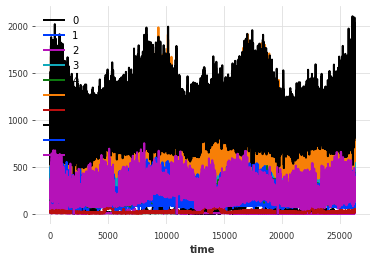

In [ ]:
series = TimeSeries.from_dataframe(data)
series.plot()

## Train and Test Split

In [ ]:
freq = '1H'
prediction_window = 1*24
context_window = 7*24

# test of Darts

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
import darts.utils.timeseries_generation as tg
from darts.datasets import AirPassengersDataset, EnergyDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.missing_values import fill_missing_values
from darts.utils.likelihood_models import GaussianLikelihood

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)



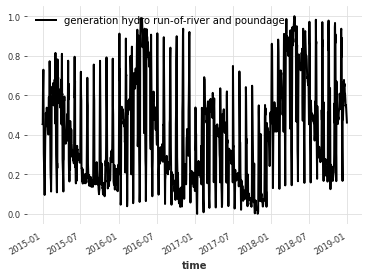

In [3]:
df3 = EnergyDataset().load().pd_dataframe()
df3_day_avg = (
    df3.groupby(df3.index.astype(str).str.split(" ").str[0]).mean().reset_index()
)
series_en = fill_missing_values(
    TimeSeries.from_dataframe(
        df3_day_avg, "time", ["generation hydro run-of-river and poundage"]
    ),
    "auto",
)

# convert to float32
series_en = series_en.astype(np.float32)

# scale
scaler_en = Scaler()
series_en_transformed = scaler_en.fit_transform(series_en)
train_en_transformed, val_en_transformed = series_en_transformed.split_after(
    pd.Timestamp("20170901")
)

# add the day as a covariate
day_series = datetime_attribute_timeseries(
    series_en_transformed, attribute="day", one_hot=True, dtype=np.float32
)
scaler_day = Scaler()
day_series = scaler_day.fit_transform(day_series)
train_day, val_day = day_series.split_after(pd.Timestamp("20170901"))

series_en_transformed.plot()


In [4]:
model_en = RNNModel(
    model="LSTM",
    hidden_dim=20,
    n_rnn_layers=2,
    dropout=0.2,
    batch_size=16,
    n_epochs=10,
    optimizer_kwargs={"lr": 1e-3},
    random_state=0,
    training_length=300,
    input_chunk_length=300,
    likelihood=GaussianLikelihood(),
)


In [5]:
model_en.fit(series=train_en_transformed, future_covariates=train_day, verbose=True)

Epoch 9: 100%|██████████| 43/43 [00:07<00:00,  5.88it/s, loss=-1.17, train_loss=-1.22]     


In [ ]:
backtest_en = model_en.historical_forecasts(
    series=series_en_transformed,
    future_covariates=day_series,
    num_samples=50,
    start=0.7,
    forecast_horizon=30,
    stride=5,
    retrain=False,
    verbose=True,
)

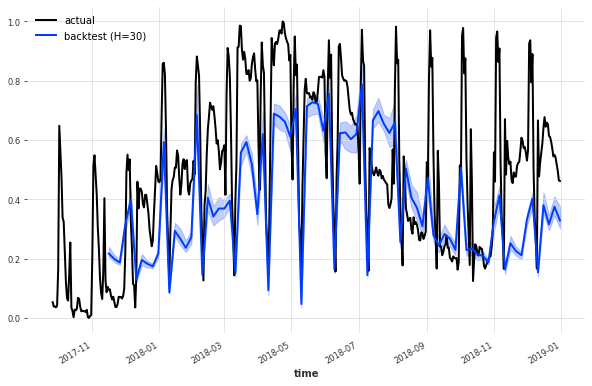

In [7]:
plt.figure(figsize=(10, 6))
series_en_transformed[1000:].plot(label="actual")
backtest_en.plot(label="backtest (H=30)", low_quantile=0.01, high_quantile=0.99)
plt.legend()

# Temporal Fusion Transformer (TFT) using Darts

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [3]:
# Read data
series = AirPassengersDataset().load()

# we convert monthly number of passengers to average daily number of passengers per month
series = series / TimeSeries.from_series(series.time_index.days_in_month)
series = series.astype(np.float32)

# Create training and validation sets:
training_cutoff = pd.Timestamp("19571201")
train, val = series.split_after(training_cutoff)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

## Create model

In [4]:
quantiles = [0.1, 0.5, 0.9]
input_chunk_length = 24
forecast_horizon = 12
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
)

## Train TFT

In [5]:
my_model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)

Training: 0it [00:00, ?it/s]

## Predictions on the validation set
perform a one-shot prediction of 24 months using the "current" model - i.e. the model at the end of the training procedure

In [7]:
# before starting, we define some constants
num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"



Predicting: 5it [00:00, ?it/s]

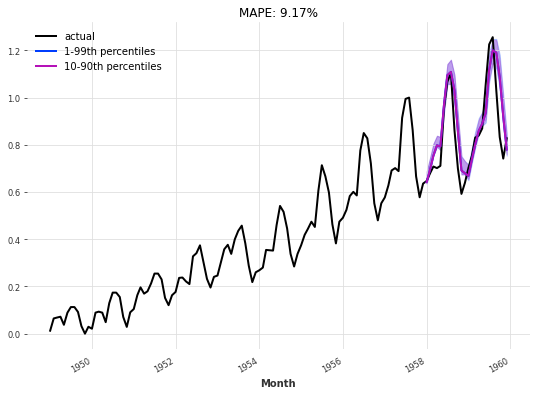

In [8]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()


eval_model(my_model, 24, series_transformed, val_transformed)

## Backtesting
Let's backtest our TFT model to see how it performs with a forecast horizon of 12 months over the last 3 years

In [9]:
backtest_series = my_model.historical_forecasts(
    series_transformed,
    future_covariates=covariates_transformed,
    start=train.end_time() + train.freq,
    num_samples=num_samples,
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,
    last_points_only=False,
    retrain=False,
    verbose=True,
)



  0%|          | 0/3 [00:00<?, ?it/s]

Predicting: 5it [00:00, ?it/s]

Predicting: 5it [00:00, ?it/s]

Predicting: 5it [00:00, ?it/s]

MAPE: 6.33%


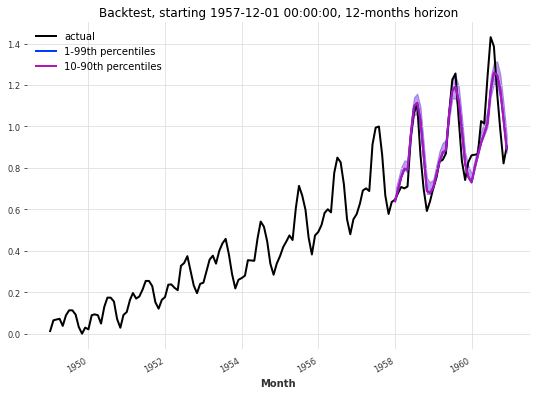

In [10]:
def eval_backtest(backtest_series, actual_series, horizon, start, transformer):
    plt.figure(figsize=figsize)
    actual_series.plot(label="actual")
    backtest_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    backtest_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)
    plt.legend()
    plt.title(f"Backtest, starting {start}, {horizon}-months horizon")
    print(
        "MAPE: {:.2f}%".format(
            mape(
                transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series),
            )
        )
    )


eval_backtest(
    backtest_series=concatenate(backtest_series),
    actual_series=series_transformed,
    horizon=forecast_horizon,
    start=training_cutoff,
    transformer=transformer,
)



# Test of GluonTS